In [1]:
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import matplotlib.image as mpimg
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=False))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

/home/family/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import os

def extract_files(parent, extension='.png'):
    file_container = []
    for root, dirs, files in os.walk(parent):
        for file in files:
            if file.endswith(extension):
                file_container.append(os.path.join(root, file))
    return file_container

In [3]:
import random

def display_random_n_images(files, num, conv= 'RGB2YCrCb'):
    
    for i in range(num):
        number = random.randint(0, len(files)-1)
        image = cv2.imread(files[number])
        #print(image.shape)
        img = convert_color(image, conv=conv)
        channel1 = img[:,:,0]
        feature, hog_image1 = get_hog_features(channel1, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=False)
        channel2 = img[:,:,1]
        feature, hog_image2 = get_hog_features(channel2, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=False)
        channel3 = img[:,:,2]
        feature, hog_image3 = get_hog_features(channel3, 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=False)
        
        f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, figsize=(15,8))
        
        ax1.imshow(image)
        ax1.set_title('origin', fontsize=30)
        ax2.imshow(channel1)
        ax2.set_title('ch1', fontsize=30)
        ax3.imshow(channel2)
        ax3.set_title('ch2', fontsize=30)
        ax4.imshow(channel3)
        ax4.set_title('ch3', fontsize=30)
        ax5.imshow(hog_image1)
        ax5.set_title('hog_ch1', fontsize=30)
        ax6.imshow(hog_image2)
        ax6.set_title('hog_ch2', fontsize=30)
        ax7.imshow(hog_image3)
        ax7.set_title('hog_ch3', fontsize=30)


In [4]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

vehicle_files_dir = './../data/vehicles/'
non_vehicle_files_dir = './../data/non-vehicles/'
cars = extract_files(vehicle_files_dir)
notcars = extract_files(non_vehicle_files_dir)
print('car label file num is ', len(cars))
print('notcar label file num is ', len(notcars))

car label file num is  8792
notcar label file num is  8968


In [5]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32
spatial_feat=True
hist_feat=True
hog_feat=True


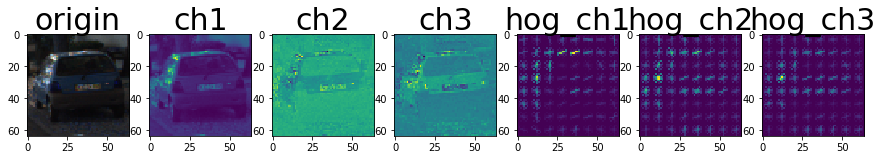

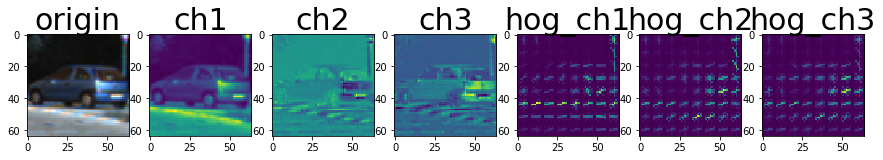

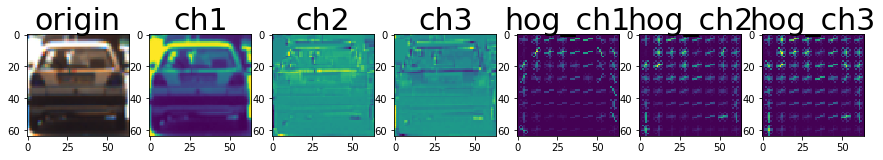

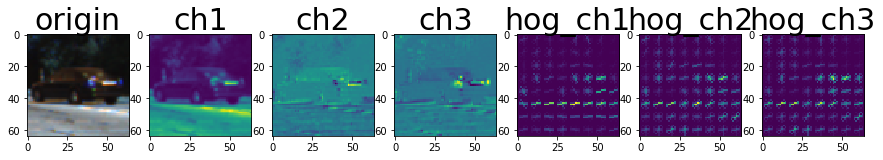

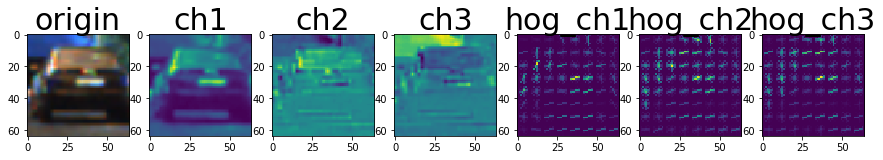

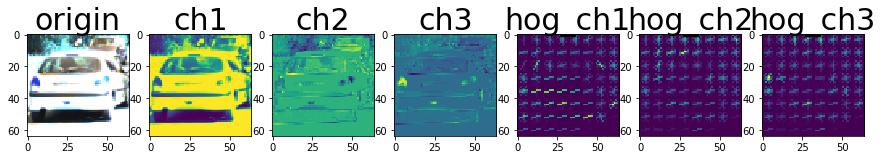

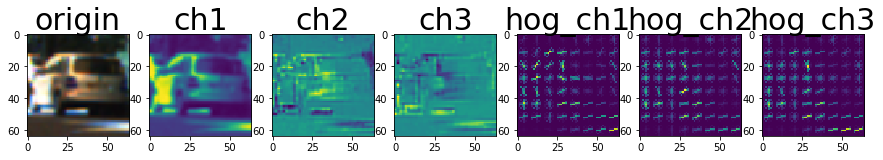

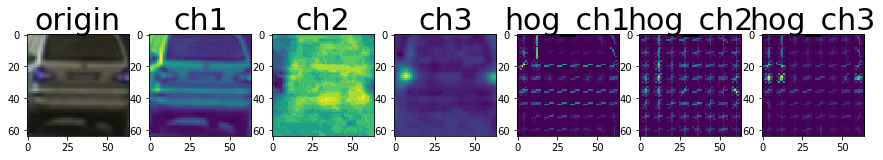

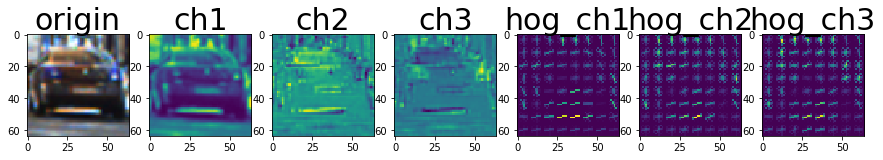

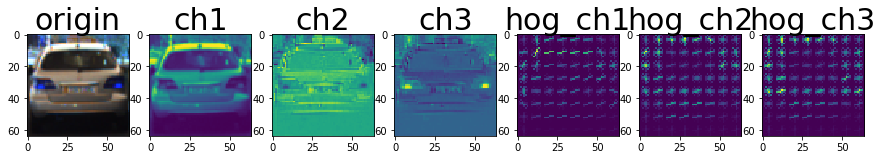

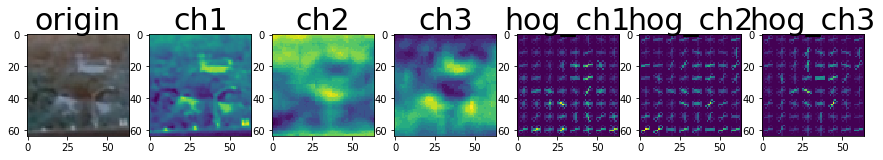

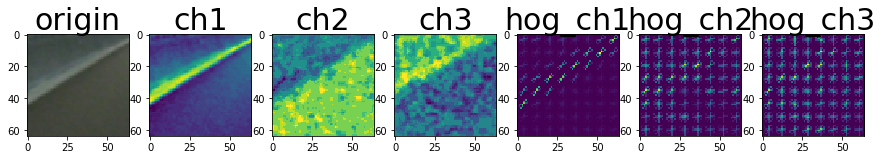

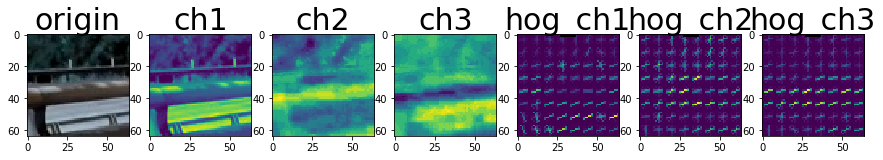

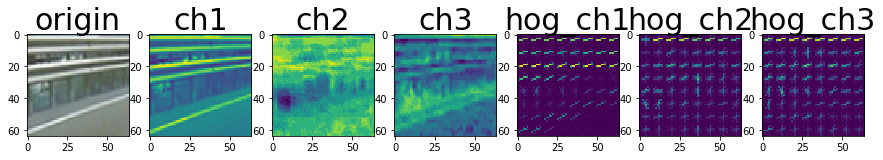

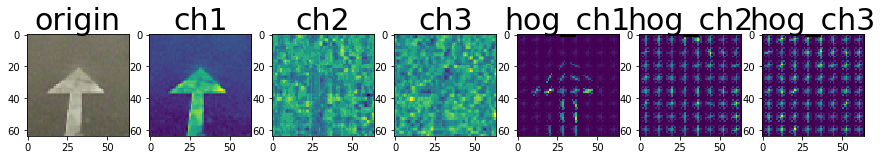

In [6]:
display_random_n_images(cars, 10, 'RGB2YCrCb')
display_random_n_images(notcars, 5, 'RGB2YCrCb')

In [7]:
t=time.time()
car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

52.15 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
5.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:      [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
0.00149 Seconds to predict 10 labels with SVC


In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    #heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

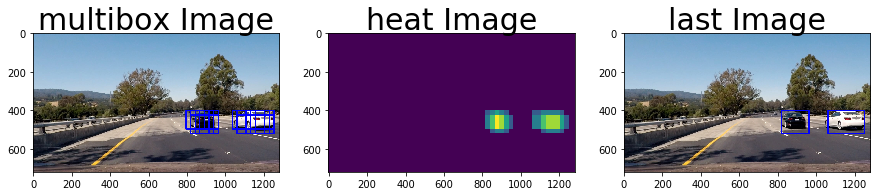

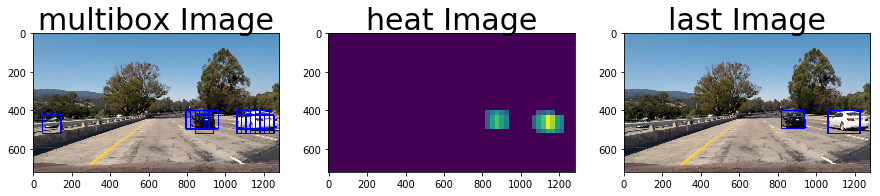

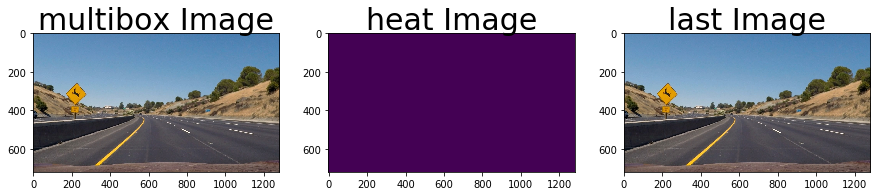

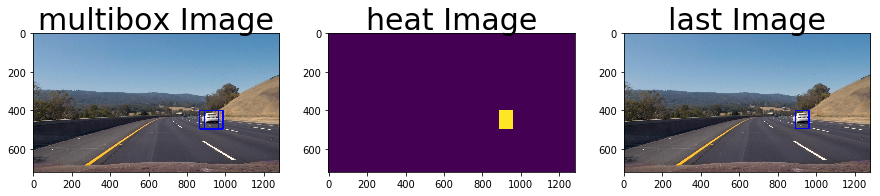

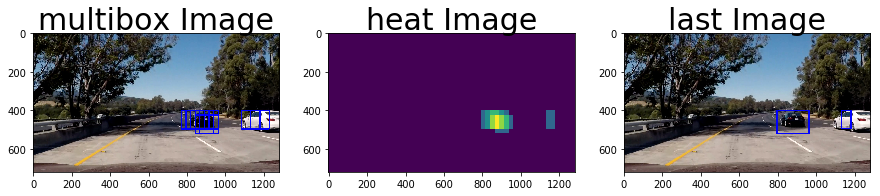

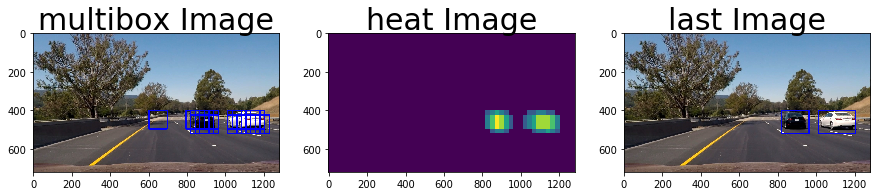

In [9]:
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_box(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    box_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(box_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(box)
    
    return bbox_list


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    box_img = np.copy(img)
    #img = img.astype(np.float32)/255
    bbox_list = find_cars_box(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    for box in bbox_list:
            cv2.rectangle(box_img,box[0],box[1],(0,0,255),6) 
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(draw_img), labels)
    return draw_img, heat, box_img

  
ystart = 400
ystop = 656
scale = 1.5
#scale = 1

images = glob.glob('./test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)     
    out_img, heat, box_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
    ax1.imshow(box_img)
    ax1.set_title('multibox Image', fontsize=30)
    ax2.imshow(heat)
    ax2.set_title('heat Image', fontsize=30)
    ax3.imshow(out_img)
    ax3.set_title('last Image', fontsize=30)
    
    #plt.imshow(out_img)


In [10]:
def process_image(img): 
    out_img, heat, box_img = find_cars(img, ystart, ystop, scale, svc,
                        X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    return out_img

In [15]:
#This class is used to maintain a queue of heat-map frames
class FrameQueue:

    def __init__(self, max_frames=10):
        self.frames = []
        self.max_frames = max_frames

    def put(self, frame):
        if len(self.frames) >= self.max_frames:
            self.frames.pop(0)
        self.frames.append(frame)

    def sum_frames(self):
        all_frames = np.array(self.frames)
        return np.sum(all_frames, axis=0)

    
class VehicleDetector:
    """
    This is the main class of the project. It encapsulates methods we created for sliding windows, feature generation,
    machine learning mode, and remove duplicates and false positives. Also, internally, it calls other utility methods
    for task such as drawing bounding boxes.
    """

    def __init__(self, classifier, X_scaler, color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2,
                 hog_channel='ALL', spatial_size=(32, 32), hist_bins=32, spatial_feat=True,
                 hist_feat=True, hog_feat=True, y_start=400, y_stop=656, scale=1.5, frame_queue_size = 30, heat_threshold =15):
        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.y_start = y_start
        self.y_stop = y_stop
        self.scale = scale
        self.X_scaler = X_scaler
        self.classifier = classifier
        self.heat_threshold = heat_threshold

        self.frame_queue = FrameQueue(frame_queue_size)

    
    def find_cars(self, image):
        draw_img = np.copy(image)
        box_img = np.copy(image)
        #img = img.astype(np.float32)/255
        bbox_list = find_cars_box(image, self.y_start, self.y_stop, self.scale, 
                                  self.classifier, self.X_scaler, self.orient, self.pix_per_cell, 
                                  self.cell_per_block, self.spatial_size, self.hist_bins)
        
        #bbox_list = find_cars_box(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
        heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,bbox_list)
        self.frame_queue.put(heat)
        new_heat = self.frame_queue.sum_frames()
    
        # Apply threshold to help remove false positives
        new_heat = apply_threshold(new_heat,self.heat_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(new_heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(draw_img), labels)
        return draw_img
    
    #lane detection and vehicle detecition pipeline in future
    def process_image(self, image):
        return image
    
    
   

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [17]:
#Create video file pipeline
vehicle = VehicleDetector(classifier=svc,X_scaler=X_scaler)
output = 'out_test_video.mp4'
clip1 = VideoFileClip('project_video.mp4')
out_clip = clip1.fl_image(vehicle.find_cars) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


100%|█████████▉| 1260/1261 [05:47<00:00,  3.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

CPU times: user 14min, sys: 1min 23s, total: 15min 24s
Wall time: 5min 47s


In [18]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))